# Random Forest Model using Bag of Words

# Imports and Constants

In [50]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import ast
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.preprocessing import LabelBinarizer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import model_helper_functions
from sklearn.model_selection import GridSearchCV

In [2]:
DATA_PATH = '../data/'
PRE_PROCESSED_DATA_FILE_NAME = 'news_dataset_pre_processed.csv'
RANDOM_STATE = 42
pd.options.display.max_seq_items = 20
pd.options.display.max_rows = 50

# Load Data

In [3]:
df = pd.read_csv(DATA_PATH + PRE_PROCESSED_DATA_FILE_NAME, 
                 low_memory = False, 
                 usecols = ['title', 'text', 'label', 'clean_text_tokens', 'clean_title_tokens'])

In [4]:
df.clean_text_tokens = df.clean_text_tokens.map(ast.literal_eval)
df.clean_title_tokens = df.clean_title_tokens.map(ast.literal_eval)

In [5]:
df.head()

,title,text,label,clean_text_tokens,clean_title_tokens
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,fake,"[donald, trump, just, couldn, wish, all, ameri...","[donald, trump, sends, out, embarrassing, new,..."
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,fake,"[house, intelligence, committee, chairman, dev...","[drunk, bragging, trump, staffer, started, rus..."
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",fake,"[on, it, was, revealed, that, former, milwauke...","[sheriff, david, clarke, becomes, an, internet..."
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",fake,"[on, christmas, day, donald, trump, announced,...","[trump, is, so, obsessed, he, even, has, obama..."
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,fake,"[pope, francis, used, his, annual, christmas, ...","[pope, francis, just, called, out, donald, tru..."


# Split Data

In [6]:
y = df.label
X = df.drop('label', axis=1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                   test_size = 0.2,
                                                   random_state = RANDOM_STATE,
                                                   stratify = y)

In [8]:
X_train.shape

(30910, 4)

In [9]:
X_test.shape

(7728, 4)

# Encode Labels

In [10]:
le = LabelEncoder()

In [11]:
y_train_enc = le.fit_transform(y_train)

In [12]:
y_test_enc = le.transform(y_test)

# Train Models

In [47]:
def train_and_eval_model(X_train, X_test, y_train_enc, y_test_enc, classes_,
                        preprocessor, tokenizer, max_df=1.0, ngram_range = (1, 1),
                        min_samples_split=2,
                        max_depth=None):
    """
    Train and Evaluate and Bag of Words Representation with a Random Forest
    classifier.
    """
    
    pipeline = Pipeline([
    ('bow',CountVectorizer(min_df = 5, 
                           preprocessor = preprocessor, 
                           tokenizer = tokenizer, 
                           max_df = max_df, 
                           ngram_range = ngram_range)),  
    ('classifier', RandomForestClassifier(n_jobs = -1, 
                                          random_state = RANDOM_STATE, 
                                          min_samples_split = min_samples_split, 
                                          max_depth = max_depth)),
    ])
    
    pipeline.fit(X_train,y_train_enc)
    
    model_helper_functions.confustion_matrix_and_classification_report(pipeline, 
                                                X_train, 
                                                y_train_enc, 
                                                classes_, 
                                               'Training')

    model_helper_functions.confustion_matrix_and_classification_report(pipeline, 
                                                X_test, 
                                                y_test_enc, 
                                                classes_,
                                                'Test')
    
    return pipeline

## title only

Classification Report for Training Set
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00     13957
        true       1.00      1.00      1.00     16953

    accuracy                           1.00     30910
   macro avg       1.00      1.00      1.00     30910
weighted avg       1.00      1.00      1.00     30910



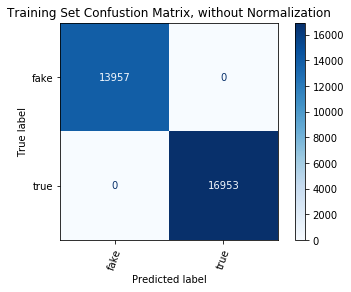

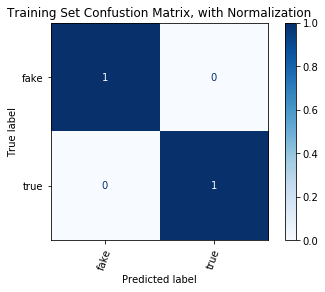

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.94      0.93      0.93      3490
        true       0.94      0.95      0.95      4238

    accuracy                           0.94      7728
   macro avg       0.94      0.94      0.94      7728
weighted avg       0.94      0.94      0.94      7728



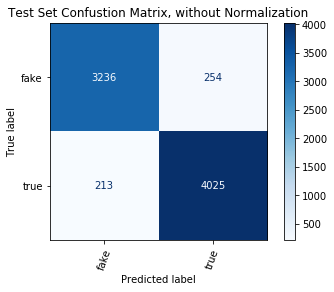

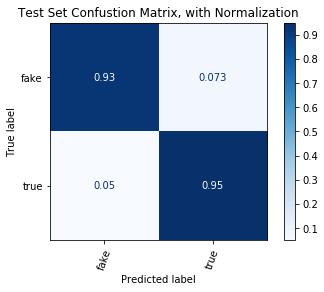

In [14]:
pipeline = train_and_eval_model(X_train = X_train['clean_title_tokens'], 
                                 X_test = X_test['clean_title_tokens'], 
                                 y_train_enc = y_train_enc, 
                                 y_test_enc = y_test_enc, 
                                 classes_ = le.classes_, 
                                 preprocessor = model_helper_functions.passthrough, 
                                 tokenizer = model_helper_functions.passthrough)

In [15]:
feature_importances = pd.DataFrame(pipeline['classifier'].feature_importances_, 
                                       index = pipeline['bow'].get_feature_names(), 
                                       columns = ['importance']).sort_values('importance', 
                                                                             ascending=False)
    
feature_importances.head(20)

,importance
VIDEO,0.065863
the,0.036135
video,0.031744
U.S.,0.025845
!,0.024778
WATCH,0.022325
just,0.015136
is,0.014924
says,0.014488
and,0.013525


## Title - Stopwords Removed

There are a lot of stopwords in the above model.  Let's see what the important features are with the stopwords removed.

Classification Report for Training Set
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00     13957
        true       1.00      1.00      1.00     16953

    accuracy                           1.00     30910
   macro avg       1.00      1.00      1.00     30910
weighted avg       1.00      1.00      1.00     30910



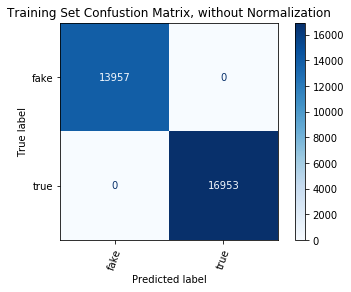

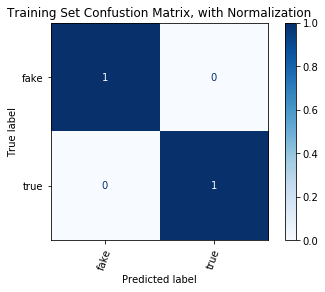

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.94      0.91      0.92      3490
        true       0.92      0.95      0.94      4238

    accuracy                           0.93      7728
   macro avg       0.93      0.93      0.93      7728
weighted avg       0.93      0.93      0.93      7728



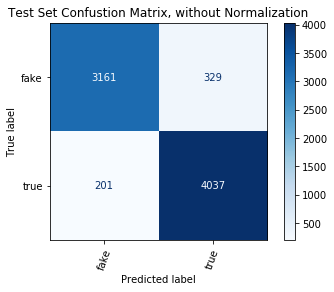

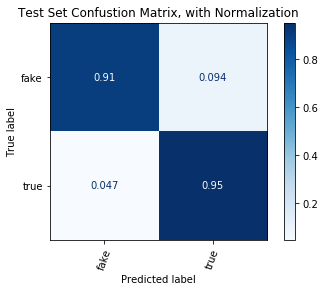

In [16]:
pipe_sw_removed = train_and_eval_model(X_train = X_train['clean_title_tokens'], 
                                 X_test = X_test['clean_title_tokens'], 
                                 y_train_enc = y_train_enc, 
                                 y_test_enc = y_test_enc, 
                                 classes_ = le.classes_, 
                                 preprocessor = model_helper_functions.passthrough, 
                                 tokenizer = model_helper_functions.remove_stopwords)

In [17]:
feat_imp_sw_removed = pd.DataFrame(pipe_sw_removed['classifier'].feature_importances_, 
                                       index = pipe_sw_removed['bow'].get_feature_names(), 
                                       columns = ['importance']).sort_values('importance', 
                                                                             ascending=False)
feat_imp_sw_removed.head(20)

,importance
VIDEO,0.077739
video,0.033181
U.S.,0.032684
!,0.029536
WATCH,0.025594
says,0.019531
hillary,0.017264
GOP,0.013599
BREAKING,0.010488
TRUMP,0.009178


## Title - Stopwords Removed and all Lowercase

About half of the important features for the above model are all caps.  Let's see which are important with everything is lowercase.

Classification Report for Training Set
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00     13957
        true       1.00      1.00      1.00     16953

    accuracy                           1.00     30910
   macro avg       1.00      1.00      1.00     30910
weighted avg       1.00      1.00      1.00     30910



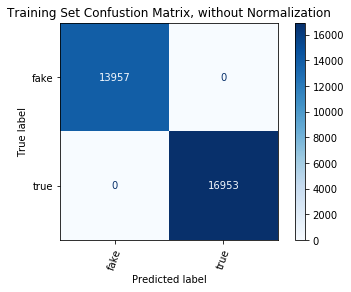

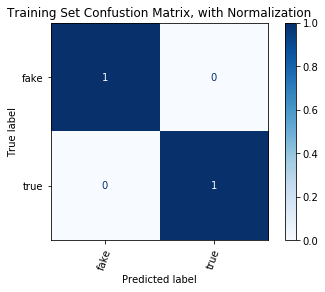

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.93      0.90      0.91      3490
        true       0.92      0.94      0.93      4238

    accuracy                           0.92      7728
   macro avg       0.92      0.92      0.92      7728
weighted avg       0.92      0.92      0.92      7728



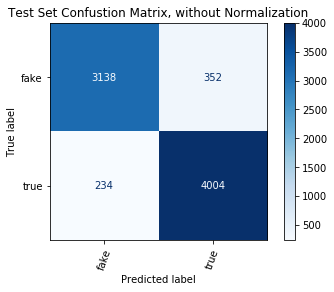

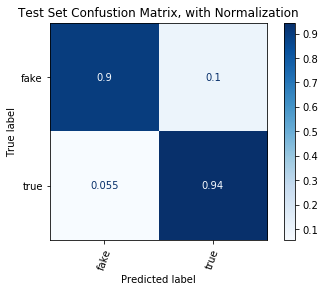

In [18]:
pipe_lc_sw_rm = train_and_eval_model(X_train = X_train['clean_title_tokens'], 
                     X_test = X_test['clean_title_tokens'], 
                     y_train_enc = y_train_enc, 
                     y_test_enc = y_test_enc, 
                     classes_ = le.classes_, 
                     preprocessor = model_helper_functions.lowercase_tokens, 
                     tokenizer = model_helper_functions.remove_stopwords)

In [19]:
feat_imp_lc_sw_rm = pd.DataFrame(pipe_lc_sw_rm['classifier'].feature_importances_, 
                                       index = pipe_lc_sw_rm['bow'].get_feature_names(), 
                                       columns = ['importance']).sort_values('importance', 
                                                                             ascending=False)
feat_imp_lc_sw_rm.head(20)

,importance
video,0.114457
u.s.,0.029262
!,0.028627
watch,0.025455
hillary,0.023230
says,0.018627
gop,0.015194
trump,0.013572
breaking,0.011002
donald,0.009403


## Title - Stopwords Removed, all Lowercase, N-Gram (1,2)

Classification Report for Training Set
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00     13957
        true       1.00      1.00      1.00     16953

    accuracy                           1.00     30910
   macro avg       1.00      1.00      1.00     30910
weighted avg       1.00      1.00      1.00     30910



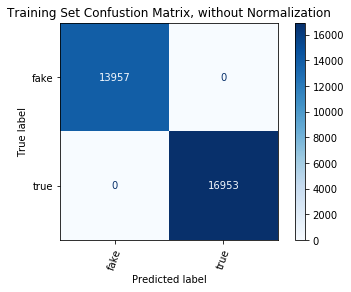

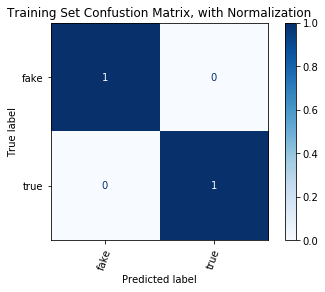

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.93      0.90      0.92      3490
        true       0.92      0.95      0.93      4238

    accuracy                           0.93      7728
   macro avg       0.93      0.92      0.93      7728
weighted avg       0.93      0.93      0.93      7728



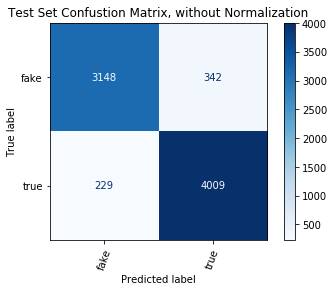

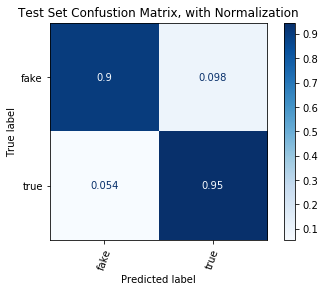

In [20]:
pipe_sw_rm_lc_ng = train_and_eval_model(X_train = X_train['clean_title_tokens'], 
                                         X_test = X_test['clean_title_tokens'], 
                                         y_train_enc = y_train_enc, 
                                         y_test_enc = y_test_enc, 
                                         classes_ = le.classes_, 
                                         preprocessor = model_helper_functions.lowercase_and_remove_stopwords, 
                                         tokenizer = model_helper_functions.passthrough, 
                                         ngram_range = (1, 2))

In [21]:
feat_imp_sw_rm_lc_ng = pd.DataFrame(pipe_sw_rm_lc_ng['classifier'].feature_importances_, 
                                       index = pipe_sw_rm_lc_ng['bow'].get_feature_names(), 
                                       columns = ['importance']).sort_values('importance', 
                                                                             ascending=False)
feat_imp_sw_rm_lc_ng.head(20)

,importance
video,0.099808
u.s.,0.030794
!,0.026789
watch,0.022678
hillary,0.020802
says,0.016225
gop,0.014977
breaking,0.010011
trump,0.009542
obama,0.008327


## Title and Text

In [22]:
X_train['title_and_text'] = X_train['clean_title_tokens'] + X_train['clean_text_tokens']
X_test['title_and_text'] = X_test['clean_title_tokens'] + X_test['clean_text_tokens']

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Classification Report for Training Set
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00     13957
        true       1.00      1.00      1.00     16953

    accuracy                           1.00     30910
   macro avg       1.00      1.00      1.00     30910
weighted avg       1.00      1.00      1.00     30910



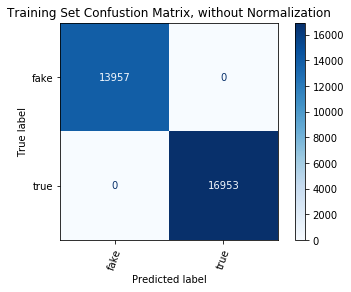

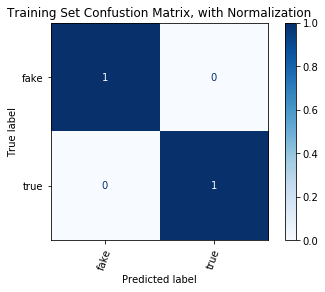

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.99      0.97      0.98      3490
        true       0.98      0.99      0.98      4238

    accuracy                           0.98      7728
   macro avg       0.98      0.98      0.98      7728
weighted avg       0.98      0.98      0.98      7728



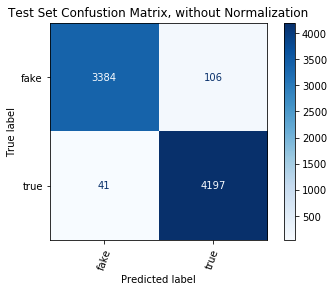

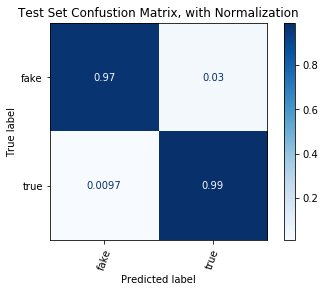

In [23]:
pipe_title_text = train_and_eval_model(X_train['title_and_text'], 
                                       X_test['title_and_text'],
                                       y_train_enc, 
                                       y_test_enc, 
                                       le.classes_, 
                                       model_helper_functions.passthrough, 
                                       model_helper_functions.passthrough)

In [24]:
feat_imp_title_text = pd.DataFrame(pipe_title_text['classifier'].feature_importances_, 
                                       index = pipe_title_text['bow'].get_feature_names(), 
                                       columns = ['importance']).sort_values('importance', 
                                                                             ascending=False)
feat_imp_title_text.head(20)

,importance
image,0.027500
said,0.026850
via,0.023226
!,0.018412
WASHINGTON,0.014797
video,0.012127
VIDEO,0.011234
twitter-handle,0.010120
U.S.,0.009552
just,0.009312


## Title and Text - lowercase, lemmatize

The above feature list contains singular and plural versions of words as well as all caps and lowercase.  Let's see what the performance and feature importances are with all lowercase and lemmatization.

Classification Report for Training Set
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00     13957
        true       1.00      1.00      1.00     16953

    accuracy                           1.00     30910
   macro avg       1.00      1.00      1.00     30910
weighted avg       1.00      1.00      1.00     30910



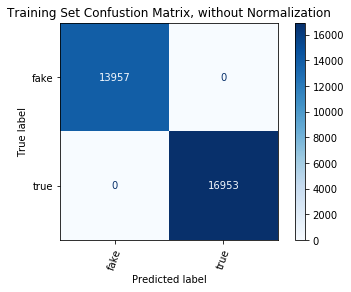

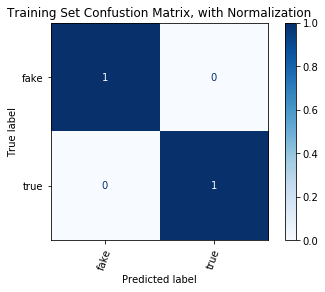

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.98      0.96      0.97      3490
        true       0.97      0.99      0.98      4238

    accuracy                           0.97      7728
   macro avg       0.97      0.97      0.97      7728
weighted avg       0.97      0.97      0.97      7728



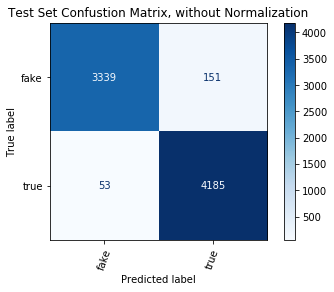

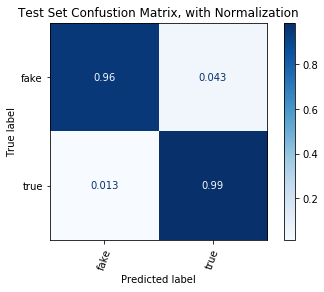

In [25]:
pipe_title_text_lc_lemma = train_and_eval_model(X_train['title_and_text'], 
                                       X_test['title_and_text'],
                                       y_train_enc, 
                                       y_test_enc, 
                                       le.classes_, 
                                       model_helper_functions.lowercase_tokens, 
                                       model_helper_functions.LemmaTokenizer())

In [26]:
feat_imp_title_text_lc_lemma = pd.DataFrame(pipe_title_text_lc_lemma['classifier'].feature_importances_, 
                                       index = pipe_title_text_lc_lemma['bow'].get_feature_names(), 
                                       columns = ['importance']).sort_values('importance', 
                                                                             ascending=False)
feat_imp_title_text_lc_lemma.head(20)

,importance
image,0.023827
said,0.022190
video,0.017770
u.s.,0.017147
!,0.016883
via,0.016717
you,0.014193
twitter-handle,0.012469
on,0.011281
just,0.009052


## Title and Text - lowercase, lemmatize, no stopwords

The list of important features from the above model contains a lot of stopwords.  Let's see what it looks like with the stopwords removed.

Classification Report for Training Set
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00     13957
        true       1.00      1.00      1.00     16953

    accuracy                           1.00     30910
   macro avg       1.00      1.00      1.00     30910
weighted avg       1.00      1.00      1.00     30910



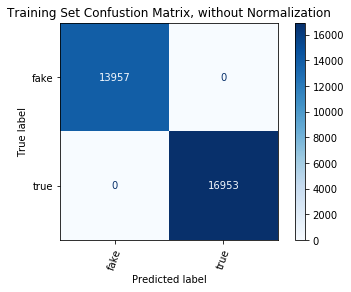

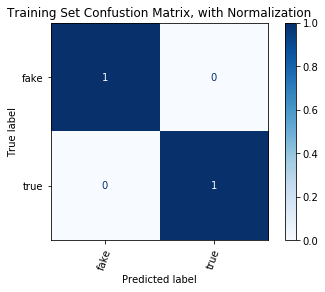

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.98      0.96      0.97      3490
        true       0.97      0.99      0.98      4238

    accuracy                           0.98      7728
   macro avg       0.98      0.98      0.98      7728
weighted avg       0.98      0.98      0.98      7728



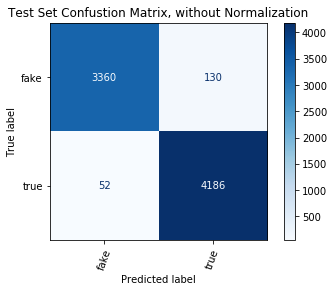

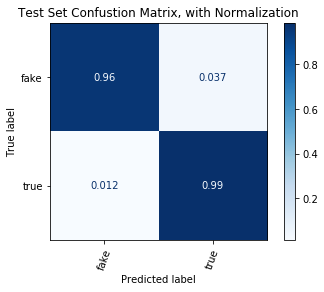

In [27]:
pipe_title_text_lc_lemma_no_sw = train_and_eval_model(X_train['title_and_text'], 
                                       X_test['title_and_text'],
                                       y_train_enc, 
                                       y_test_enc, 
                                       le.classes_, 
                                       model_helper_functions.lowercase_and_remove_stopwords, 
                                       model_helper_functions.LemmaTokenizer())

In [28]:
feat_imp_title_text_lc_lemma = pd.DataFrame(pipe_title_text_lc_lemma_no_sw['classifier'].feature_importances_, 
                                       index = pipe_title_text_lc_lemma_no_sw['bow'].get_feature_names(), 
                                       columns = ['importance']).sort_values('importance', 
                                                                             ascending=False)
feat_imp_title_text_lc_lemma.head(20)

,importance
via,0.032236
said,0.030576
video,0.025144
image,0.022269
u.s.,0.018250
!,0.017779
twitter-handle,0.009260
like,0.007889
washington,0.007884
know,0.007637


## Title & Text - lowercase, lemmatize, no stopwords, n-grams [1,2]

Classification Report for Training Set
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00     13957
        true       1.00      1.00      1.00     16953

    accuracy                           1.00     30910
   macro avg       1.00      1.00      1.00     30910
weighted avg       1.00      1.00      1.00     30910



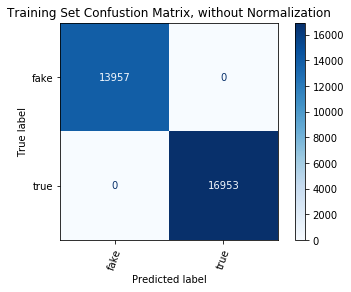

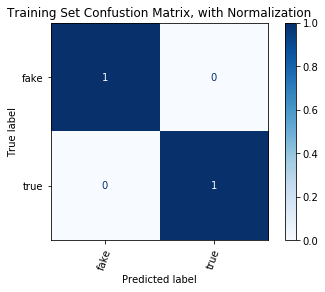

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.99      0.97      0.98      3490
        true       0.97      0.99      0.98      4238

    accuracy                           0.98      7728
   macro avg       0.98      0.98      0.98      7728
weighted avg       0.98      0.98      0.98      7728



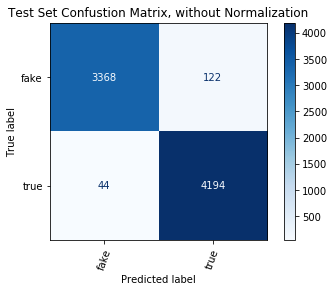

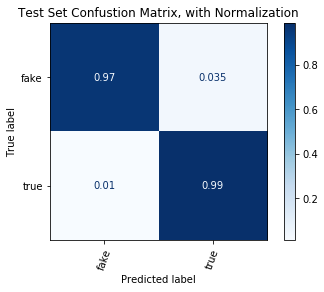

In [29]:
pipe_title_text_lc_lemma_no_sw_ng = train_and_eval_model(X_train['title_and_text'], 
                                                        X_test['title_and_text'],
                                                        y_train_enc, 
                                                        y_test_enc, 
                                                        le.classes_, 
                                                        model_helper_functions.lowercase_and_remove_stopwords, 
                                                        model_helper_functions.LemmaTokenizer(), 
                                                        ngram_range = (1, 2))

In [30]:
feat_imp_title_text_lc_lemma_no_sw_ng = pd.DataFrame(pipe_title_text_lc_lemma_no_sw_ng['classifier'].feature_importances_, 
                                       index = pipe_title_text_lc_lemma_no_sw_ng['bow'].get_feature_names(), 
                                       columns = ['importance']).sort_values('importance', 
                                                                             ascending=False)
feat_imp_title_text_lc_lemma_no_sw_ng.head(30)

,importance
said,0.022254
image via,0.013539
video,0.012442
u.s.,0.011672
!,0.011194
via,0.011180
image,0.008511
president donald,0.006625
twitter-handle,0.006596
minister,0.006256


Researching why a * u * is an important feature, I found that *us* which could have always been *us* or it could have been *US* is lemmatized to *u*. [link](https://stackoverflow.com/questions/54784287/nltk-wordnetlemmatizer-processes-us-as-u)

## Title & Text - lowercase, only stopwords

What if we look at only the stopwords.

In [31]:
def lowercase_and_only_stopwords(doc):
    """Remove stopwords and lowercase tokens"""
    stop_words = stopwords.words('english')
    return [token.lower() for token in doc if token.lower() in stop_words]

Classification Report for Training Set
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00     13957
        true       1.00      1.00      1.00     16953

    accuracy                           1.00     30910
   macro avg       1.00      1.00      1.00     30910
weighted avg       1.00      1.00      1.00     30910



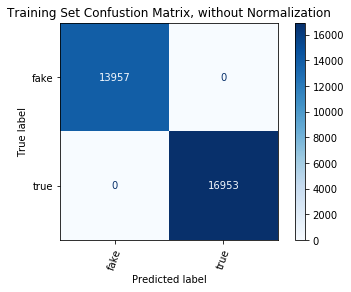

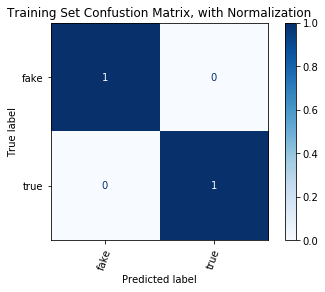

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.91      0.86      0.88      3490
        true       0.89      0.93      0.91      4238

    accuracy                           0.90      7728
   macro avg       0.90      0.90      0.90      7728
weighted avg       0.90      0.90      0.90      7728



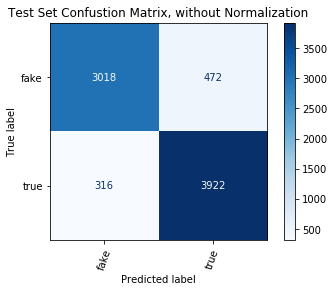

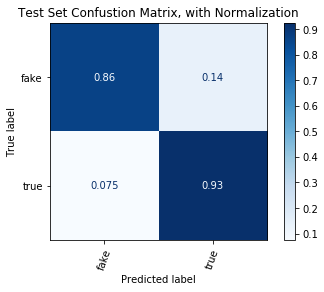

In [32]:
pipe_title_text_lc_only_sw = train_and_eval_model(X_train['title_and_text'], 
                                                        X_test['title_and_text'],
                                                        y_train_enc, 
                                                        y_test_enc, 
                                                        le.classes_, 
                                                        lowercase_and_only_stopwords, 
                                                        model_helper_functions.passthrough)

In [33]:
feat_imp_title_text_lc_only_sw = pd.DataFrame(pipe_title_text_lc_only_sw['classifier'].feature_importances_, 
                                       index = pipe_title_text_lc_only_sw['bow'].get_feature_names(), 
                                       columns = ['importance']).sort_values('importance', 
                                                                             ascending=False)
feat_imp_title_text_lc_only_sw.head(30)

,importance
on,0.069433
you,0.067328
just,0.046957
in,0.037294
its,0.035668
this,0.032857
here,0.032484
is,0.026043
the,0.025722
what,0.024075


The model is starting to overfit.  I'll try to reduce the overfitting.

Regardless it is interesting that the data can be stripped to only stopwords and still have F1 scores around 0.9 and an accuracy of 0.9.

### Try to reduce overfitting



#### Set the Min Samples Split to 10%

This seems a bit high, but I want to see how far the F1 and Accuracy scores go down.

Classification Report for Training Set
              precision    recall  f1-score   support

        fake       0.82      0.83      0.83     13957
        true       0.86      0.85      0.86     16953

    accuracy                           0.84     30910
   macro avg       0.84      0.84      0.84     30910
weighted avg       0.84      0.84      0.84     30910



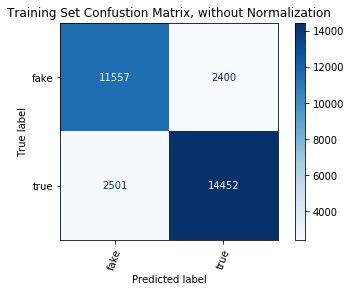

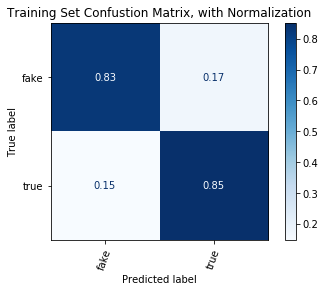

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.82      0.82      0.82      3490
        true       0.85      0.85      0.85      4238

    accuracy                           0.84      7728
   macro avg       0.83      0.83      0.83      7728
weighted avg       0.84      0.84      0.84      7728



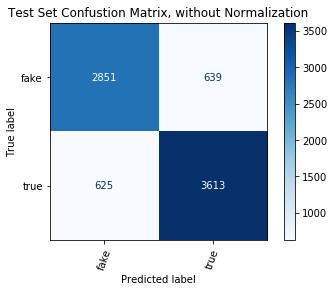

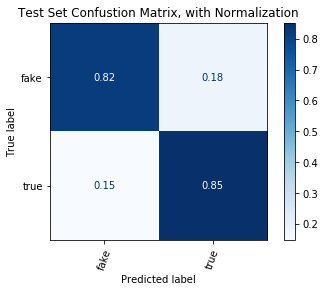

In [48]:
pipe_title_text_lc_only_sw_mdf = train_and_eval_model(X_train['title_and_text'], 
                                                        X_test['title_and_text'],
                                                        y_train_enc, 
                                                        y_test_enc, 
                                                        le.classes_, 
                                                        lowercase_and_only_stopwords, 
                                                        model_helper_functions.passthrough,
                                                 min_samples_split = 0.1)

In [49]:
feat_imp_title_text_lc_only_sw_mdf = pd.DataFrame(pipe_title_text_lc_only_sw_mdf['classifier'].feature_importances_, 
                                       index = pipe_title_text_lc_only_sw_mdf['bow'].get_feature_names(), 
                                       columns = ['importance']).sort_values('importance', 
                                                                             ascending=False)
feat_imp_title_text_lc_only_sw_mdf.head(30)

,importance
you,0.146251
just,0.087114
here,0.076946
on,0.070290
its,0.062726
what,0.059823
so,0.054932
this,0.054082
is,0.035830
didn,0.031387


The F1 and Accuracy scores went down by about 0.05 each, but the model is no longer overfit.

#### Grid Search

I'll try a grid search on the Min Samples Split parameter to see if I can improve the scores while maintaining the fitness of the model.

In [70]:
param_grid = {'classifier__min_samples_split': [0.005, 0.01, 0.05, 0.1]}

In [71]:
def train_and_eval_grid_search(X_train, X_test, y_train_enc, y_test_enc, classes_,
                        preprocessor, tokenizer, max_df=1.0, ngram_range = (1, 1)):
                               
    pipeline = Pipeline([
                        ('bow',CountVectorizer(min_df = 5, 
                                               preprocessor = preprocessor, 
                                               tokenizer = tokenizer, 
                                               max_df = max_df, 
                                               ngram_range = ngram_range)),  
                        ('classifier', RandomForestClassifier(n_jobs = -1, 
                                                              random_state = RANDOM_STATE)),
                        ])

    gs = GridSearchCV(estimator=pipeline, param_grid=param_grid, n_jobs=-1)

    gs.fit(X_train,y_train_enc)

    model_helper_functions.confustion_matrix_and_classification_report(gs.best_estimator_, 
                                                X_train, 
                                                y_train_enc, 
                                                classes_, 
                                               'Training')

    model_helper_functions.confustion_matrix_and_classification_report(gs.best_estimator_, 
                                                X_test, 
                                                y_test_enc, 
                                                classes_,
                                                'Test')




    return gs

Classification Report for Training Set
              precision    recall  f1-score   support

        fake       0.91      0.89      0.90     13957
        true       0.91      0.92      0.92     16953

    accuracy                           0.91     30910
   macro avg       0.91      0.91      0.91     30910
weighted avg       0.91      0.91      0.91     30910



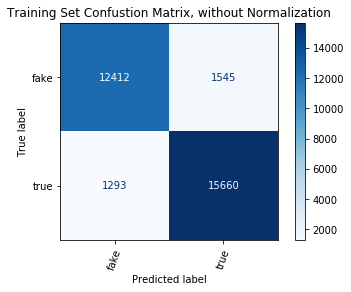

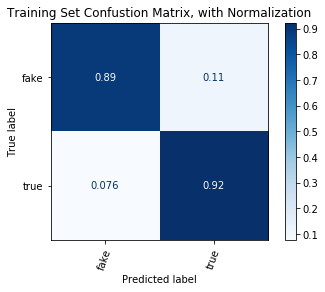

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.88      0.86      0.87      3490
        true       0.89      0.91      0.90      4238

    accuracy                           0.89      7728
   macro avg       0.89      0.88      0.88      7728
weighted avg       0.89      0.89      0.89      7728



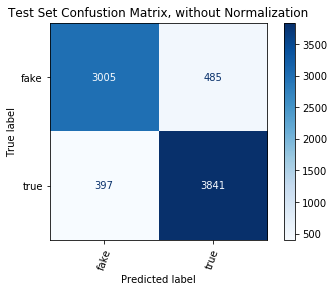

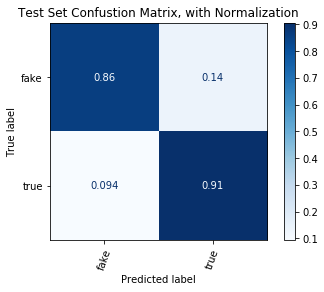

In [72]:
gs = train_and_eval_grid_search(X_train['title_and_text'], 
                                                        X_test['title_and_text'],
                                                        y_train_enc, 
                                                        y_test_enc, 
                                                        le.classes_, 
                                                        lowercase_and_only_stopwords, 
                                                        model_helper_functions.passthrough)

In [73]:
gs.best_params_

{'classifier__min_samples_split': 0.005}

In [74]:
feat_imp_gs = pd.DataFrame(gs.best_estimator_['classifier'].feature_importances_, 
                                       index = gs.best_estimator_['bow'].get_feature_names(), 
                                       columns = ['importance']).sort_values('importance', 
                                                                             ascending=False)
feat_imp_gs.head(30)

,importance
you,0.114799
on,0.094423
just,0.078319
here,0.058881
its,0.056958
this,0.045528
what,0.041143
in,0.040786
so,0.034076
is,0.030866


## Title & Text only - lowercase, only stopwords, but a larger set of them.

Can I improve the model performance by increasing the size of the set of stopwords?

I'll use the best min_samples_split value from the above model.

In [75]:
# using expanded stopwords list from https://gist.github.com/sebleier/554280

gist_file = open(DATA_PATH + "gist_stopwords.txt", "r")
try:
    content = gist_file.read()
    expanded_stopwords = content.split(",")
finally:
    gist_file.close()

In [76]:
def lowercase_and_only_expanded_stopwords(doc):
    """Remove stopwords and lowercase tokens"""
    stop_words = expanded_stopwords
    return [token.lower() for token in doc if token.lower() in stop_words]

Classification Report for Training Set
              precision    recall  f1-score   support

        fake       0.97      0.95      0.96     13957
        true       0.96      0.97      0.97     16953

    accuracy                           0.97     30910
   macro avg       0.97      0.96      0.97     30910
weighted avg       0.97      0.97      0.97     30910



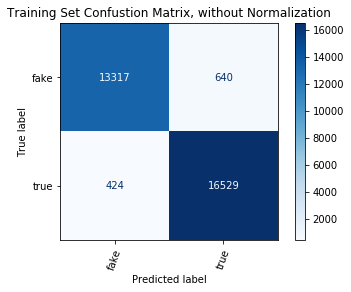

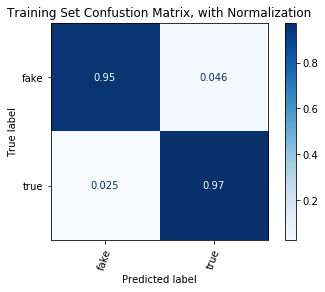

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.95      0.93      0.94      3490
        true       0.94      0.96      0.95      4238

    accuracy                           0.94      7728
   macro avg       0.95      0.94      0.94      7728
weighted avg       0.94      0.94      0.94      7728



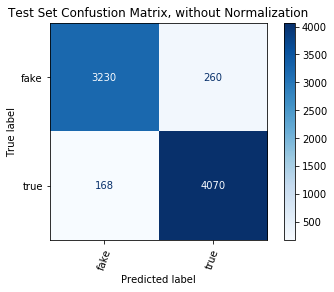

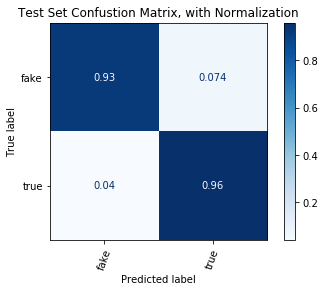

In [77]:
pipe_expanded_sw = train_and_eval_model(X_train['title_and_text'], 
                                                        X_test['title_and_text'],
                                                        y_train_enc, 
                                                        y_test_enc, 
                                                        le.classes_, 
                                                        lowercase_and_only_expanded_stopwords, 
                                                        model_helper_functions.passthrough,
                                                 min_samples_split = 0.005)

In [78]:
feat_imp_expanded_sw = pd.DataFrame(pipe_expanded_sw['classifier'].feature_importances_, 
                                       index = pipe_expanded_sw['bow'].get_feature_names(), 
                                       columns = ['importance']).sort_values('importance', 
                                                                             ascending=False)
feat_imp_expanded_sw.head(30)

,importance
said,0.134472
via,0.100337
you,0.054095
on,0.047520
just,0.039439
here,0.024647
its,0.023799
this,0.021877
didn,0.019454
like,0.019429


Using the expanded stopword list increased the F1 and accuracy scores for the test set, while not overfitting the model to particular people, events, organizations or hashtags.  Although these are news stories, many of them quote tweets which would contain hash tags.